# 0. Imports and add functions

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from functions import utils, get_features

from functions.plotting import plot_conformers

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/q_/pxh8rpm1021bvcmqb5qg17p00000gn/T/ipykernel_83004/775336684.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
paramsscreen = {'backend': 'ps',
            'axes.labelsize': 15,
           'legend.fontsize': 15,
           'xtick.labelsize': 13,
           'ytick.labelsize': 13,
           'axes.titlesize': 16}

plt.rcParams.update(paramsscreen)

# 1. Define paths and ligand IDs

In [3]:
conformers_path = Path("./calculation_files/crest/5kcal_clustered")
features_path = Path("./feature_files/individual_ligands")
dft_features_path = Path("./feature_files/dft_opt_sp_features.csv")

xyz_files = []
for path in conformers_path.glob("*.xyz"):
    xyz_files.append(path)

ligands = ["pp000067", "pp000085", "pp000091", "pp000110", "pp000133", "pp000135",
           "pp000298", "pp000321", "pp000390", "pp000425", "pp000458", "pp000670"]

# 2. Collect GFN2-xTB energies and descriptors for each ligand set

Generates a .csv file for each ligand in the unique IDs list generated above containing:
- ligand and conformer number
- GFN2-xTB energy (extracted from the 2nd line in the .xyz coordinate file)
- bite angle
- buried volume at 3.5 Å
- three descriptors from a solid angle calculation (solid angle, solid cone angle, G-parameter) - only solid cone angle is used later

All descriptors are calculated using MORFEUS [add link...]

**Once all descriptors are collected, this does not need to be run again**

In [4]:
for ligand in ligands:

    # generates lists of the conformer paths and file names
    conformers = []
    conformer_names = []
    for xyz_file in xyz_files:
        if ligand in xyz_file.name:
            conformers.append(xyz_file)
            conformer_names.append(xyz_file.name)

    expected_jobs = len(conformers)

    # generates a list of the xTB energies from the .xyz files (2nd line of the file)
    energies = []
    for conformer in tqdm(conformers, total=expected_jobs, desc=f"Collecting energies for {ligand}"):
        energy = utils.get_xtb_energy(conformer)
        energies.append(energy)

    # generates a list of calculated bite angles using MORFEUS
    bite_angles = []
    for conformer in tqdm(conformers, total=expected_jobs, desc=f"Collecting bite angles for {ligand}"):
        bite_angle = get_features.get_bite_angle(conformer)
        bite_angles.append(bite_angle)

    # generates a list of calculated buried volumes at 3.5 Å using MORFEUS
    buried_volumes = []
    for conformer in tqdm(conformers, total=expected_jobs, desc=f"Collecting buried volumes for {ligand}"):
        buried_volume = get_features.get_buried_volume(conformer)
        buried_volumes.append(buried_volume)

    # generates a series of lists based on calculated Solid Angles using MORFEUS
    solid_angles = []
    solid_cone_angles = []
    g_parameters = []
    for conformer in tqdm(conformers, total=expected_jobs, desc=f"Collecting solid angles for {ligand}"):
        solid_angle, solid_cone_angle, g_param = get_features.get_solid_angle(conformer)
        solid_angles.append(solid_angle)
        solid_cone_angles.append(solid_cone_angle)
        g_parameters.append(g_param)

    # converts above lists into a dictionary and generates a CSV file with descriptors for each ligand
    ligand_dict = {'ligand': conformer_names, 'xtb_energy': energies, 'bite_angle': bite_angles,
        'buried_volume': buried_volumes, 'solid_angle': solid_angles, 'solid_cone_angle': solid_cone_angles,
        'g_parameter': g_parameters}
    ligand_df = pd.DataFrame(ligand_dict)
    ligand_df['bite_angle_buried_volume'] = ligand_df['bite_angle'] * ligand_df['buried_volume']
    ligand_df['bite_angle_cone_angle'] = ligand_df['bite_angle'] * ligand_df['solid_cone_angle']
    ligand_df.to_csv(features_path / f"{ligand}.csv")

    print(f"Feature collection completed for {ligand}")


Feature collection completed for pp000067


Feature collection completed for pp000085


Feature collection completed for pp000091


Feature collection completed for pp000110


Feature collection completed for pp000133


Feature collection completed for pp000135


Feature collection completed for pp000298


Feature collection completed for pp000321


Feature collection completed for pp000390


Feature collection completed for pp000425


Feature collection completed for pp000458


Feature collection completed for pp000670


# 3. Select equidistant conformers
## 3.1. Setup selection/plotting

Define variables to determine how conformers are selected and how the results are plotted:
- `ligand_to_analyze`: is the ID for the ligand to analyze (this must be in the list of unique IDs generated in Section 1)
- `df`: is the dataframe which loads the energies and descriptors from the .csv file generated in Section 2
- `descriptors`: is a list of descriptors used to analyze/select conformers - *do not make this longer than 3 descriptors*

In [5]:
ligand_to_analyze = 'pp000390'
df = pd.read_csv(features_path / f"{ligand_to_analyze}.csv")
features = ['bite_angle', 'solid_cone_angle', 'bite_angle_buried_volume']

## 3.2. Plotting

### 3.2.1. Equidistant selection based on feature values

Change the arguments in the below function to change how the selection is plotted:
- `write_text_file`: set this to `True` if you would like a .txt file containing the conformers selected to be generated (this also gets printed in the notebook) - this is necessary for running Section 4.
- `savefig`: set this to `True` if you would like to save the plot as a SVG file.

The default number of conformers to be selected is **10**. This can be changed by adding the `sele_num=##` to the plotting function, where `##` is the number of conformers to be selected (integer)

Selected ligands from bite_angle: 
pp000390-Pd_7.xyz
pp000390-Pd_17.xyz
pp000390-Pd_13.xyz
pp000390-Pd_11.xyz
pp000390-Pd_8.xyz
pp000390-Pd_4.xyz
pp000390-Pd_2.xyz
pp000390-Pd_16.xyz
pp000390-Pd_1.xyz
pp000390-Pd_5.xyz
LEC: pp000390-Pd_1.xyz
-------------------------------------------

Selected ligands from solid_cone_angle: 
pp000390-Pd_15.xyz
pp000390-Pd_12.xyz
pp000390-Pd_13.xyz
pp000390-Pd_4.xyz
pp000390-Pd_8.xyz
pp000390-Pd_10.xyz
pp000390-Pd_17.xyz
pp000390-Pd_3.xyz
pp000390-Pd_9.xyz
pp000390-Pd_14.xyz
LEC: pp000390-Pd_1.xyz
-------------------------------------------

Selected ligands from bite_angle_buried_volume: 
pp000390-Pd_7.xyz
pp000390-Pd_4.xyz
pp000390-Pd_2.xyz
pp000390-Pd_3.xyz
pp000390-Pd_15.xyz
pp000390-Pd_10.xyz
pp000390-Pd_17.xyz
pp000390-Pd_11.xyz
pp000390-Pd_8.xyz
pp000390-Pd_9.xyz
LEC: pp000390-Pd_1.xyz
-------------------------------------------



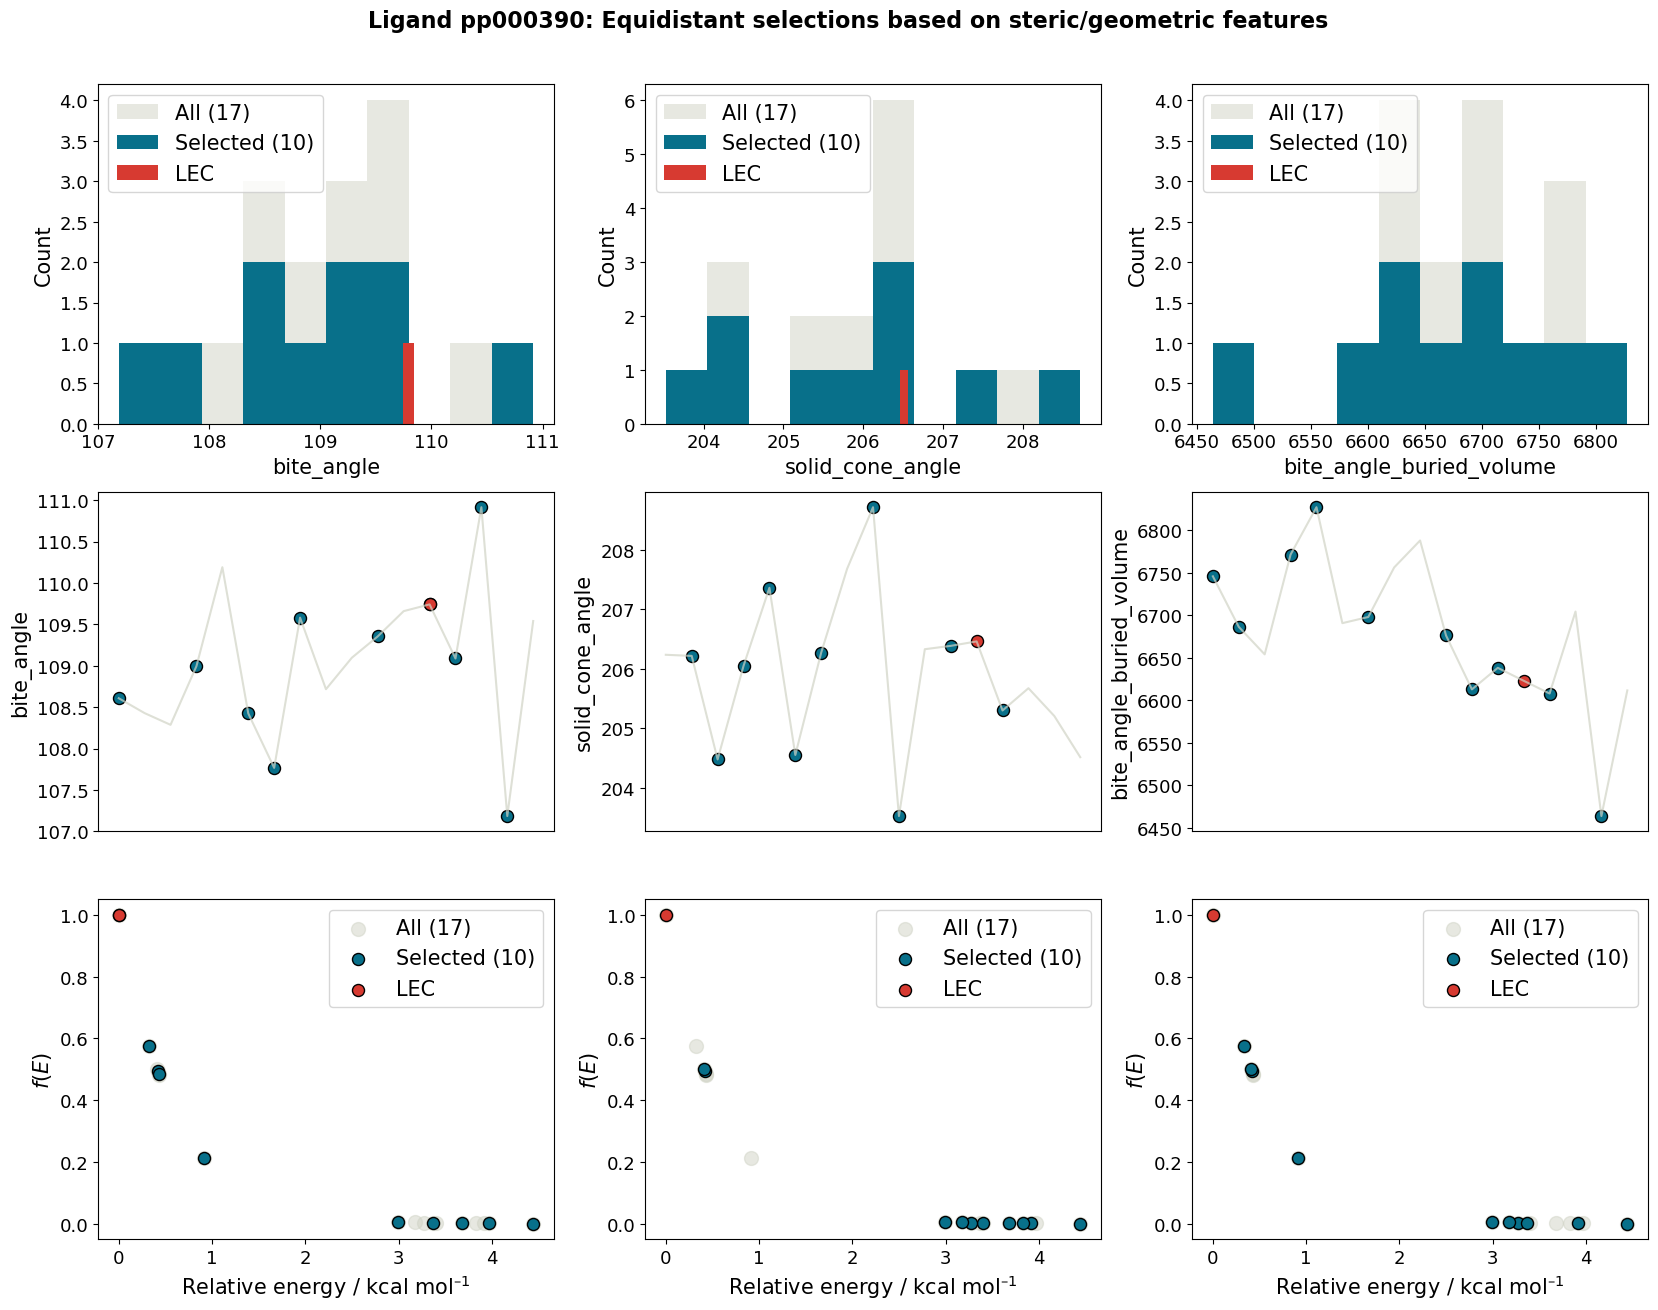

In [6]:
plot_conformers.plot_equidistant_feature_selections(df, ligand_id=ligand_to_analyze, features=features, 
                                                text_file_path=features_path, write_text_file=True, savefig=False)

### 3.2.2. Equidistant selection based on GFN2-xTB energy

Arguments in this function are exactly the same as the selection based on feature values

Selected ligands from energy: 
pp000390-Pd_1.xyz
pp000390-Pd_2.xyz
pp000390-Pd_4.xyz
pp000390-Pd_6.xyz
pp000390-Pd_8.xyz
pp000390-Pd_9.xyz
pp000390-Pd_11.xyz
pp000390-Pd_13.xyz
pp000390-Pd_15.xyz
pp000390-Pd_17.xyz
-------------------------------------------



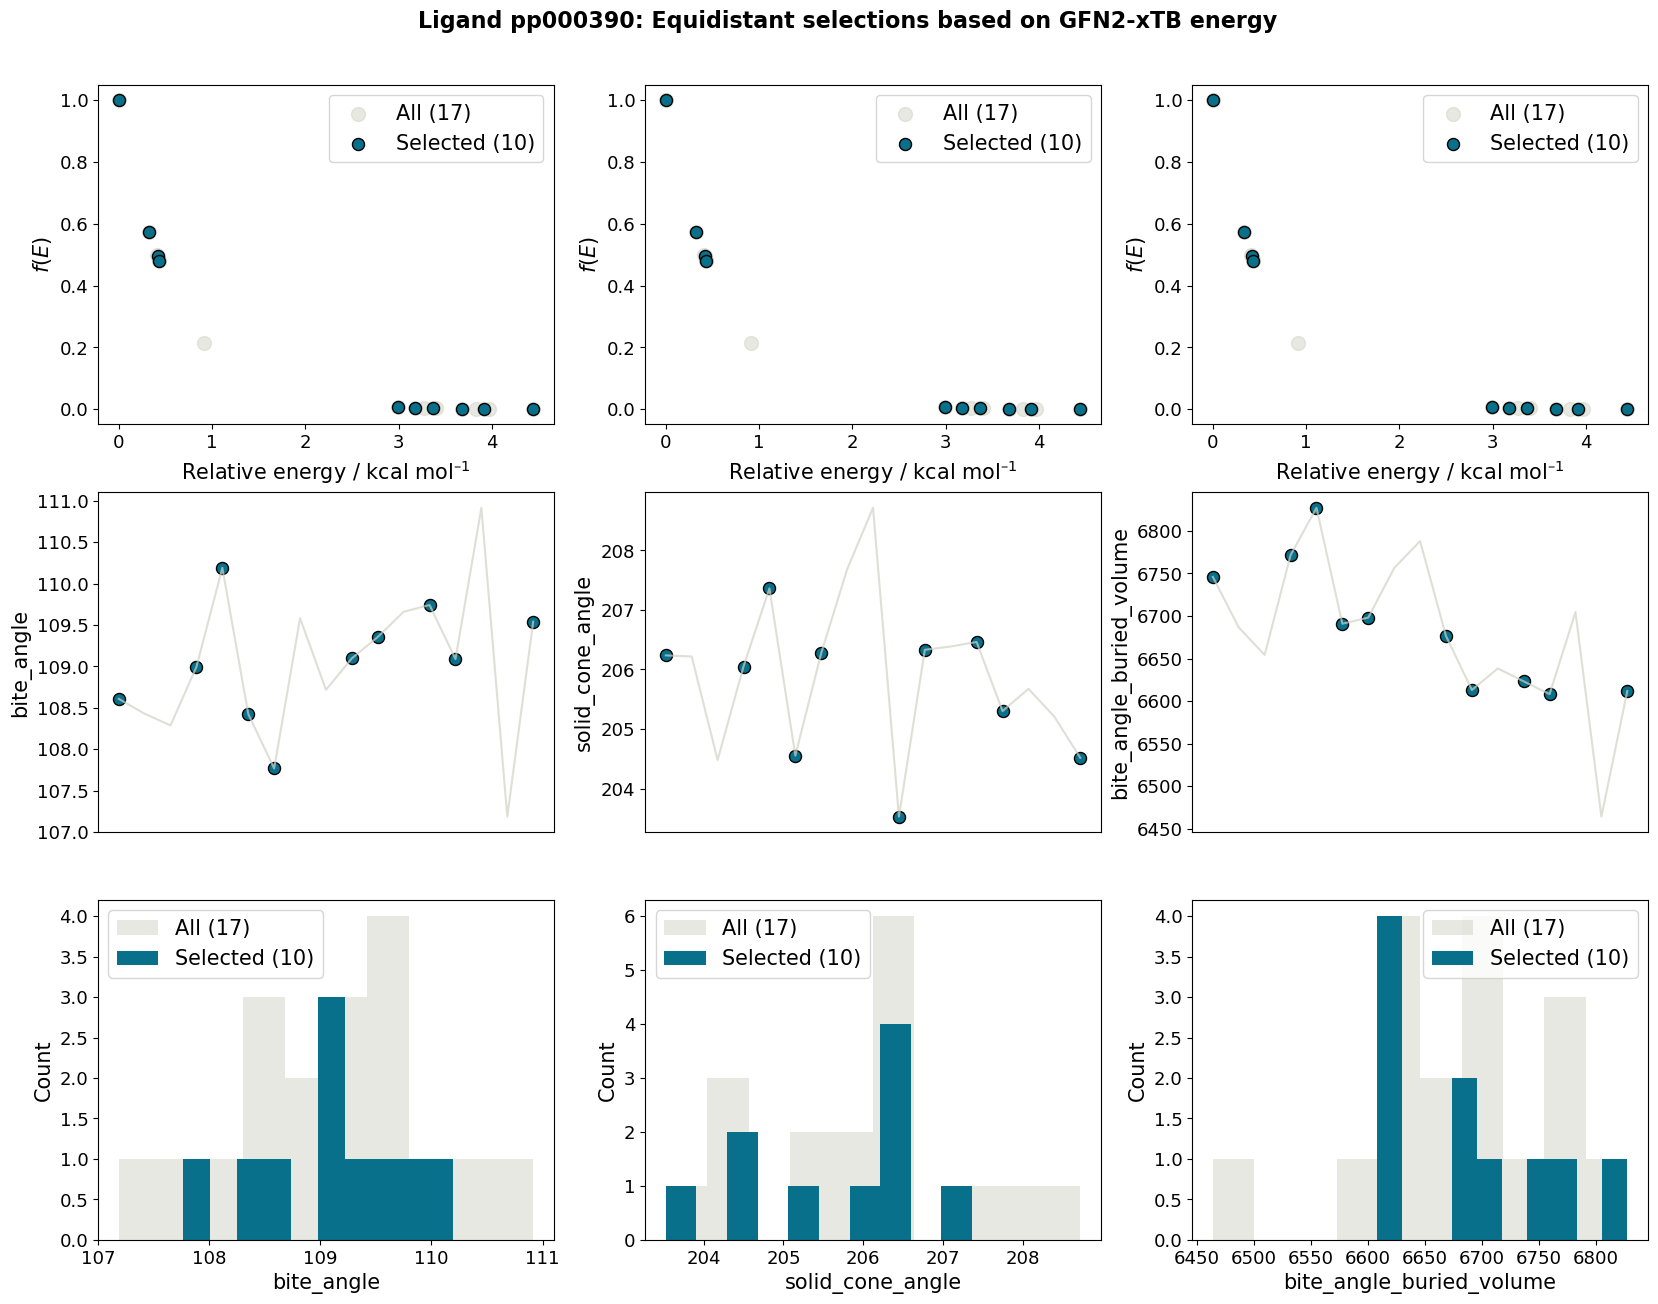

In [7]:
plot_conformers.plot_equidistant_energy_selections(df, ligand_id=ligand_to_analyze, features=features, 
                                                text_file_path=features_path, write_text_file=True, savefig=False)

# 4. Plot selected conformers on DFT descriptor distributions

## 4.1. Generate lists of selected conformers

This section uses the .txt files generated in Section 3 which contain all the selected conformers based on energy and feature values. The variable `ligand_to_analyze` is used here to select the conformer to analyze, which is defined in Section 3. The default number of selected conformers is **10**, this can be changed by adding the adding the `sele_num=##` argument to the read txt file function

In [8]:
txt_files = []
for path in features_path.glob("*.txt"):
    txt_files.append(path.name)

selected_conformers_file = [filename for filename in txt_files if ligand_to_analyze in filename][0]

In [9]:
bite_angle_selections, buried_volume_selections = utils.read_selection_txt_file(features_path / selected_conformers_file)

print("Conformers selected based on bite angle:")
print('\n'.join(map(str, bite_angle_selections)))
print(f"Conformers selected based on buried volume:")
print('\n'.join(map(str, buried_volume_selections)))

Conformers selected based on bite angle:
pp000390-Pd_1.xyz
pp000390-Pd_7.xyz
pp000390-Pd_17.xyz
pp000390-Pd_13.xyz
pp000390-Pd_11.xyz
pp000390-Pd_8.xyz
pp000390-Pd_4.xyz
pp000390-Pd_2.xyz
pp000390-Pd_16.xyz
pp000390-Pd_5.xyz
Conformers selected based on buried volume:
pp000390-Pd_1.xyz
pp000390-Pd_7.xyz
pp000390-Pd_4.xyz
pp000390-Pd_2.xyz
pp000390-Pd_3.xyz
pp000390-Pd_15.xyz
pp000390-Pd_10.xyz
pp000390-Pd_17.xyz
pp000390-Pd_11.xyz
pp000390-Pd_8.xyz
pp000390-Pd_9.xyz


## 4.2. Set analysis criteria

Set criteria here for the selection feature to examine and the DFT-derived descriptor histograms to plot

In [10]:
selection_criterion = 'bite_angle'

dft_descriptors = ['HOMO', 'LUMO', 'NBO_charge_Cl_av', 'NBO_charge_P_av', 'NBO_charge_Pd', 'NMR_shift_P_av', 'aniso_NMR_shift_P_av',
                  'distance_Pd_Cl(Å)_av', 'distance_Pd_P(Å)_av', '%Vbur_Pd_3Å', '%Vbur_Pd_4Å', '%Vbur_Pd_5Å', '%Vbur_Pd_6Å', '%Vbur_Pd_7Å',
                  'Bite_angle_Pd(°)', 'volume(Bohr_radius³/mol)', 'SASA_Pd_surface_area(Å²)', 'Solid_cone_angle_Pd(°)']

## 4.3. Read in DFT features

Read in DFT features .csv file and average phosphorus features

In [11]:
# open dft features CSV file
dft_features_df = pd.read_csv(dft_features_path)

# get average features
dft_features_df['NBO_charge_Cl_av'] = dft_features_df[['NBO_charge_Cl1', 'NBO_charge_Cl2']].mean(axis=1)
dft_features_df['NBO_charge_P_av'] = dft_features_df[['NBO_charge_P1', 'NBO_charge_P2']].mean(axis=1)
dft_features_df['NMR_shift_P_av'] = dft_features_df[['NMR_shift_P1', 'NMR_shift_P2']].mean(axis=1)
dft_features_df['aniso_NMR_shift_P_av'] = dft_features_df[['aniso_NMR_shift_P1', 'aniso_NMR_shift_P2']].mean(axis=1)
dft_features_df['distance_Pd_Cl(Å)_av'] = dft_features_df[['distance_Pd_Cl1(Å)', 'distance_Pd_Cl2(Å)']].mean(axis=1)
dft_features_df['distance_Pd_P(Å)_av'] = dft_features_df[['distance_Pd_P1(Å)', 'distance_Pd_P2(Å)']].mean(axis=1)

## 4.4. Filter DFT features based on analysis criteria

In [12]:
selected_log_names = []

if selection_criterion == "bite_angle":
    for i in bite_angle_selections:
        log = f"{i.split('.')[0]}_SPE"
        selected_log_names.append(log)
elif selection_criterion == "buried_volume":
    for i in buried_volume_selections:
        log = f"{i.split('.')[0]}_SPE"
        selected_log_names.append(log)

all_dft_features = dft_features_df[dft_features_df['log_name'].str.contains(ligand_to_analyze)]
selected_dft_features = dft_features_df.loc[dft_features_df['log_name'].isin(selected_log_names)]

## 4.5. Plot DFT distributions

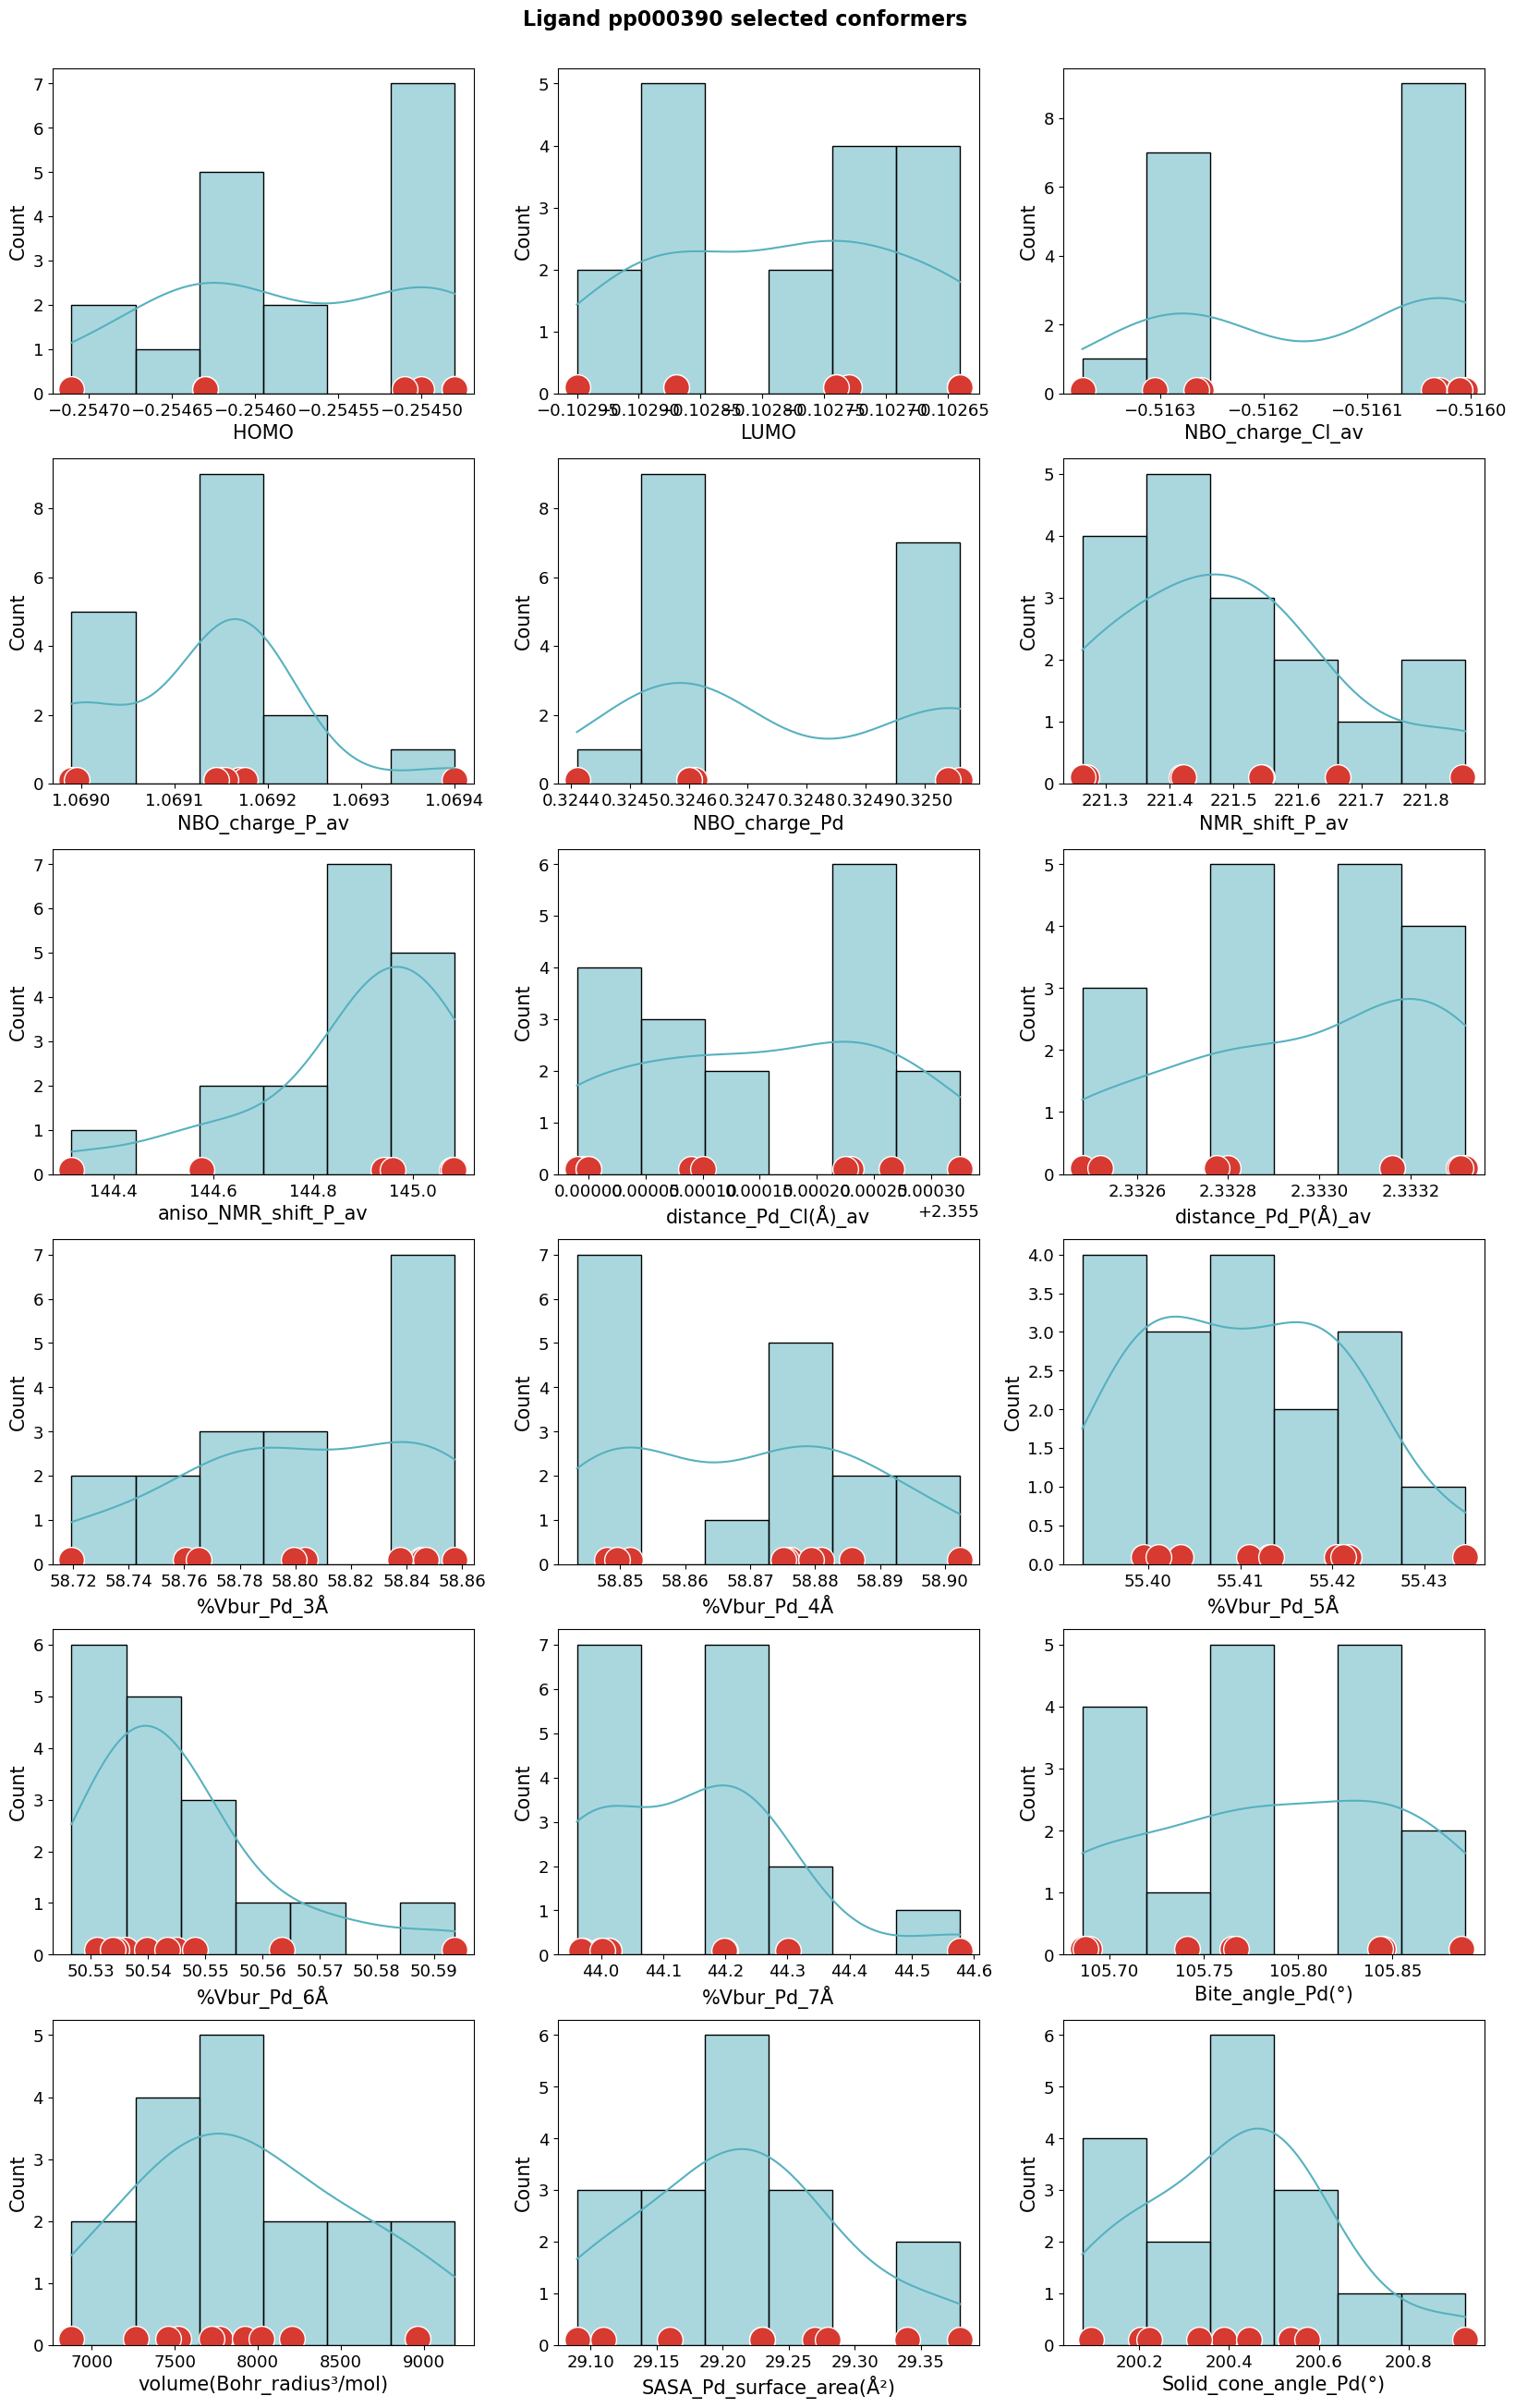

In [13]:
plot_conformers.plot_dft_distributions(all_dft_features, selected_dft_features, ligand_to_analyze, dft_descriptors)